In [2]:
import scanpy as sc
import os
import requests
import gzip
import shutil
from tqdm import tqdm
from anndata import AnnData as ad
import pandas as pd

In [3]:
from celldreamer.paths import DATA_DIR

Read dataset 

In [4]:
def load_dataset(path, url, new_name=None):
    # Check if the file exists at the specified path
    if not os.path.exists(path):
        # If not, download the file from the URL
        print(f"Dataset not found at {path}. Downloading from {url}...")
        gz_path = path + '.gz'  # Temporary path for the compressed file
        response = requests.get(url, stream=True)

        # Get the total file size for progress bar
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kilobyte

        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(gz_path, 'wb') as f:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()

        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, something went wrong")

        print("Download complete. Decompressing the file...")

        # Decompress the .gz file
        with gzip.open(gz_path, 'rb') as f_in:
            with open(path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        os.remove(gz_path)  # Remove the compressed file
        print("Decompression complete.")

    # Rename the dataset file if new_name is provided
    if new_name:
        os.rename(path, new_name)
        path = new_name

    # Load the dataset using Scanpy
    dataset = sc.read_h5ad(path)
    return dataset

dataset_path = os.path.join(DATA_DIR, 'raw', 'neurips.h5ad')
dataset_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE194122&format=file&file=GSE194122%5Fopenproblems%5Fneurips2021%5Fcite%5FBMMC%5Fprocessed%2Eh5ad%2Egz'

adata = load_dataset(path=dataset_path, url=dataset_url, new_name=dataset_path)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

Save counts 

In [5]:
adata.layers["X_counts"] = adata.X.copy()

HVG selection

In [6]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="X_counts",
    subset=True,
)

Preprocess

In [7]:
sc.pp.log1p(adata)

In [8]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

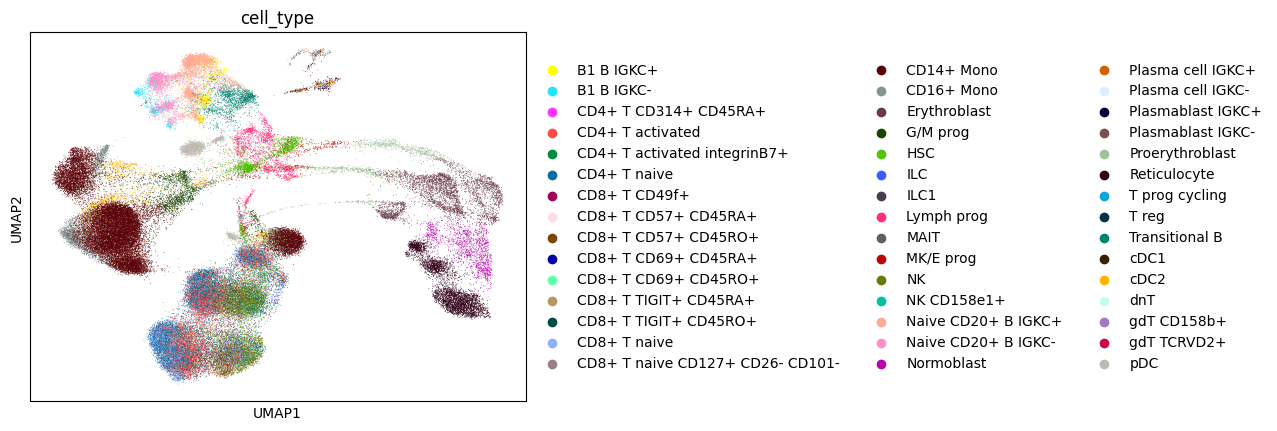

In [9]:
sc.pl.umap(adata, color=["cell_type"])

In [10]:
adata

AnnData object with n_obs × n_vars = 90261 × 2002
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'dataset_id', 'genome', 'organism', 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'X_counts'
    obsp: 'distances', 'connectivities'

Save

In [11]:
processed_dataset_path = os.path.join(DATA_DIR, 'processed', 'neurips.h5ad')

ad.write_h5ad(adata, processed_dataset_path)

In [12]:
adata.obs["lib_size"] = adata.layers["X_counts"].A.sum(1)

In [13]:
adata.obs.lib_size

GCATTAGCATAAGCGG-1-s1d1       487.538971
TACAGGTGTTAGAGTA-1-s1d1       414.288757
AGGATCTAGGTCTACT-1-s1d1       418.375366
GTAGAAAGTGACACAG-1-s1d1       363.928284
TCCGAAAAGGATCATA-1-s1d1    116903.632812
                               ...      
GAATCACCACGGAAGT-1-s4d9       579.737244
GCTGGGTGTACGGATG-1-s4d9       421.905365
TCGAAGTGTGACAGGT-1-s4d9       481.254791
GCAGGCTGTTGCATAC-1-s4d9       455.427429
ACGTAACAGGTCTACT-1-s4d9       435.188293
Name: lib_size, Length: 90261, dtype: float32

In [14]:
adata.obs.groupby("cell_type").lib_size.mean()

cell_type
B1 B IGKC+                            399.675140
B1 B IGKC-                            374.749146
CD4+ T CD314+ CD45RA+                 432.292328
CD4+ T activated                      303.830811
CD4+ T activated integrinB7+          319.252808
CD4+ T naive                          297.240326
CD8+ T CD49f+                         308.966827
CD8+ T CD57+ CD45RA+                  358.944397
CD8+ T CD57+ CD45RO+                  428.856415
CD8+ T CD69+ CD45RA+                  357.134216
CD8+ T CD69+ CD45RO+                  349.291565
CD8+ T TIGIT+ CD45RA+                 274.009521
CD8+ T TIGIT+ CD45RO+                 275.373016
CD8+ T naive                          322.346588
CD8+ T naive CD127+ CD26- CD101-      430.937775
CD14+ Mono                            274.650909
CD16+ Mono                            283.151459
Erythroblast                         3020.742676
G/M prog                              362.022247
HSC                                   372.831207
ILC       

In [17]:
adata = sc.read_h5ad("../../datasets/processed/hlca_core.h5ad")

In [18]:
adata

AnnData object with n_obs × n_vars = 584944 × 2000
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'o

In [28]:
adata_small = sc.pp.subsample(adata, fraction=0.08, random_state=0, copy=True)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


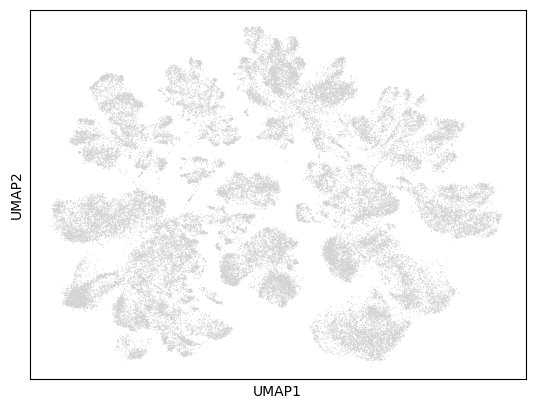

In [29]:
sc.pl.umap(adata_small)

In [30]:
adata_small

AnnData object with n_obs × n_vars = 46795 × 2000
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'or